# PHONOS
## Analyze source collection, plot and cluster

This notebook includes the code to analyze the collection of sounds compiled in the previous notebook and that will be later used as the source collection in our audio mosaicing code. The notebook also contains the code to analyze the target audio file that will be later reconstructed using sound chunks from the source collection.

The audio analysis carried out in this notebook uses the Pythonn bindings of the Essentia library which was introduced in the first session of AMPLAB. Please make sure you checked the [Essentia Python tutorial](https://essentia.upf.edu/documentation/essentia_python_tutorial.html) to get familiarized with using Essentia in Python. Also useful is to always have a browser tab opened with Essentia's [Algorithms Reference](https://essentia.upf.edu/documentation/algorithms_reference.html) documentation page.

In [1]:
!pip3 install librosa

In [57]:
import os 
from os import listdir
from os.path import isfile, join
import json
import pandas as pd
import essentia
import essentia.standard as estd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Audio

### build sound collection

In [2]:
DATASET_DIR = './phonos_dataset_local/' 
DATAFRAME_CSV_TRACKS = './files/tracks.csv'

def is_sound(file):
    return file.lower().endswith(('.wav', '.aiff'))

def make_pandas_record(sound_name, file_path = DATASET_DIR): 
    """Create a dictionary with the metadata that we want to store for each sound.""" 
    record = {}
#    record = {key: sound_name.as_dict()[key] for key in METADATA_FIELDS}
    record['track_id'] = sound_name # name will be id
    record['path'] = file_path + sound_name
    return record

def build_sound_collection(sound_files_path, csv_filename):
    # Make a Pandas DataFrame with the metadata of our sound collection and save it
    tracks = [f for f in listdir(sound_files_path) if isfile(join(sound_files_path, f)) and is_sound(join(sound_files_path, f))]
    df =  pd.DataFrame([make_pandas_record(tr, DATASET_DIR) for tr in tracks])
    df.sort_values('track_id', inplace=True) #alphabetically

    df.to_csv(csv_filename)
    print('Saved DataFrame with {0} entries! {1}'.format(len(df), csv_filename))    
    return df, tracks

df, _ = build_sound_collection(DATASET_DIR, DATAFRAME_CSV_TRACKS)
    
df.head(5)

Saved DataFrame with 90 entries! ./files/tracks.csv


,path,track_id
46,./phonos_dataset_local/all_alone.wav,all_alone.wav
18,./phonos_dataset_local/arpegio1_19_07.aiff,arpegio1_19_07.aiff
66,./phonos_dataset_local/arpegio1_filtered_lower...,arpegio1_filtered_lowered.wav
59,./phonos_dataset_local/arpegio1_impro.aiff,arpegio1_impro.aiff
60,./phonos_dataset_local/chords_ethereal_mallets...,chords_ethereal_mallets.wav


In [3]:
# Define here our sound analysis function
# NOTE: remember that if you update this function and want to run a new analysis you'll need to re-run both 
# this cell and the cells below that carry out the audio analysis and that call the analysis function. 
# After analyzing the source collection or the target file, make sure to correct descriptors have been 
# extracted by checking the DataFrame contents. DataFrame contents can be printed on screen as a table 
# using 'display(data_frame_object)'


#TODO: at the moment there is not hop-size!!!
def analyze_sound(audio_path, frame_size=None, audio_id=None):
    """Analyze the audio file given in 'sound_path'.
    Use the parameter 'frame_size' to set the size of the chunks in which the audio will 
    be split for analysis. If no frame_size is given, the whole audio will be analyzed as 
    a single frame.
    Use the 'audio_id' parameter to pass a custom identifier for the audio that will be 
    included in the analysis results. This can be useful to later identify to which file an analysis belongs.
    """
    analysis_output = []  # Here we'll store the analysis results for each chunk (frame) of the audio file
    
    # Load audio file
    #loader = estd.MonoLoader(filename=audio_path)
    loader = estd.EqloudLoader(filename=audio_path) #normalizes gain 

    audio = loader()
    
    # Some processing of frame_size parameter to avoid later problems
    if frame_size is None:
        frame_size = len(audio)  # If no frame_size is given use no frames (analyze all audio at once)
    if frame_size % 2 != 0:
        frame_size = frame_size + 1 # Make frame size even
    
    # Calculate the start and end samples for each equally-spaced audio frame
    frame_start_samples = range(0, len(audio), frame_size)
    frame_start_end_samples = zip(frame_start_samples[:-1], frame_start_samples[1:])

    # extract key and scale
    key_algo = estd.KeyExtractor()
    key, scale, key_strength = key_algo(audio)
    
    # Loudness extractor
    loudness_algo = estd.Loudness()
    
    # MFCC coefficients extractor
    w_algo = estd.Windowing(type = 'hann')
    spectrum_algo = estd.Spectrum()
    mfcc_algo = estd.MFCC()
    
    
    # Iterate over audio frames and analyze each one
    for count, (fstart, fend) in enumerate(frame_start_end_samples):
        
        # Get corresponding audio chunk and initialize dictionary to store analysis results with some basic metadata
        frame = audio[fstart:fend]
        frame_output = {
            'track_id': audio_id,
            'frame_id': '{0}_f{1}'.format(audio_id, count),
            'path': audio_path,
            'start_sample': fstart,
            'end_sample': fend,
        }
        
        # Extract loudness
        loudness = loudness_algo(frame)
        frame_output['loudness'] = loudness / len(frame)  # Normnalize by length of frame

        # Extract MFCC coefficients
        spec = spectrum_algo(w_algo(frame))
        _, mfcc_coeffs = mfcc_algo(spec)
        frame_output.update({'mfcc_{0}'.format(j): mfcc_coeffs[j] for j in range(0, len(mfcc_coeffs))})
        
        # Other tonal features
        key, scale, key_strength = key_algo(frame)
        frame_output.update({'scale': scale,
                             'key_strength': key_strength})

        
        # Add frame analysis results to output
        analysis_output.append(frame_output)

    return analysis_output
    

## Analyze source collection

In [4]:
#DATAFRAME_FILENAME = 'dataframe.csv'  # DataFrame file of the sound source collection to analyze
#DATAFRAME_SOURCE_FILENAME = 'dataframe_source.csv'  # DataFrame file where to store the results of our analysis
#FRAME_SIZE = 8820

#TODO: at the moment there is not hop-size!!! 
def analyze_source_collection(dataframe_source, dataframe_results, frame_size=8820):
    #print('frame size ', frame_size )
    # Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
    df = pd.read_csv(open(dataframe_source), index_col=0)
    analyses = []
    for i in range(0, len(df)):
        sound = df.iloc[i]  # Get DataFrame sound at position 'i'
        print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['track_id'], i + 1, len(df)))
        analysis_output = analyze_sound(sound['path'], frame_size=frame_size, audio_id=sound['track_id'])  # Split audio in chunks of 200ms (44100/5 samples)
        analyses += analysis_output

    # Store analysis results in a new Pandas DataFrame and save it
    df_source = pd.DataFrame(analyses)
    df_source.to_csv(dataframe_results)
    print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), dataframe_results))

    display(df_source)  # Show DataFrane contents
    df_source.describe()  # Show some statistics of numerical fields in the DataFrame
    return df


#analyze_source_collection(DATAFRAME_FILENAME, DATAFRAME_SOURCE_FILENAME)



## Analyze sources files and the target sound file

In [5]:
FRAME_SIZE_LOW_LEVEL = 2048
FRAME_SIZE_TONAL = 4096 #TODO how to deal with different frame sizes when bulking on the same dataframe

# DataFrame file where to store the results of our analysis
DATAFRAME_CSV_ANALYSIS = './files/tracks_analysis.csv'  

analyze_source_collection(
    DATAFRAME_CSV_TRACKS,
    DATAFRAME_CSV_ANALYSIS, 
    FRAME_SIZE_TONAL)


df = pd.read_csv(DATAFRAME_CSV_ANALYSIS) 


Analyzing sound with id all_alone.wav [1/90]
Analyzing sound with id arpegio1_19_07.aiff [2/90]
Analyzing sound with id arpegio1_filtered_lowered.wav [3/90]
Analyzing sound with id arpegio1_impro.aiff [4/90]
Analyzing sound with id chords_ethereal_mallets.wav [5/90]
Analyzing sound with id chords_funk_clav_3.wav [6/90]
Analyzing sound with id chords_organ.wav [7/90]
Analyzing sound with id chords_organ2.wav [8/90]
Analyzing sound with id chords_realistic_marimba.wav [9/90]
Analyzing sound with id chords_realistic_vibraphone.wav [10/90]
Analyzing sound with id chords_reverse_engineering.wav [11/90]
Analyzing sound with id chords_short_worm.wav [12/90]
Analyzing sound with id chords_solid_clav.wav [13/90]
Analyzing sound with id crotale01.aiff [14/90]
Analyzing sound with id crotale02.aiff [15/90]
Analyzing sound with id crotaleBrakeDrum01.aiff [16/90]
Analyzing sound with id crotaleBrakeDrum02.aiff [17/90]
Analyzing sound with id crotaleBrakeDrum03.aiff [18/90]
Analyzing sound with id c

,end_sample,frame_id,key_strength,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_2,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,scale,start_sample,track_id
0,4096,all_alone.wav_f0,0.769967,0.000000e+00,-1138.420044,0.000011,-0.000027,-0.000031,-0.000038,-0.000061,...,-0.000061,0.000023,-0.000027,-0.000053,-0.000046,-0.000023,./phonos_dataset_local/all_alone.wav,major,0,all_alone.wav
1,8192,all_alone.wav_f1,0.769967,0.000000e+00,-1138.420044,0.000011,-0.000027,-0.000031,-0.000038,-0.000061,...,-0.000061,0.000023,-0.000027,-0.000053,-0.000046,-0.000023,./phonos_dataset_local/all_alone.wav,major,4096,all_alone.wav
2,12288,all_alone.wav_f2,0.769967,0.000000e+00,-1138.420044,0.000011,-0.000027,-0.000031,-0.000038,-0.000061,...,-0.000061,0.000023,-0.000027,-0.000053,-0.000046,-0.000023,./phonos_dataset_local/all_alone.wav,major,8192,all_alone.wav
3,16384,all_alone.wav_f3,0.769967,0.000000e+00,-1138.420044,0.000011,-0.000027,-0.000031,-0.000038,-0.000061,...,-0.000061,0.000023,-0.000027,-0.000053,-0.000046,-0.000023,./phonos_dataset_local/all_alone.wav,major,12288,all_alone.wav
4,20480,all_alone.wav_f4,0.769967,1.407930e-08,-1138.420044,0.000011,-0.000027,-0.000031,-0.000038,-0.000061,...,-0.000061,0.000023,-0.000027,-0.000053,-0.000046,-0.000023,./phonos_dataset_local/all_alone.wav,major,16384,all_alone.wav
5,24576,all_alone.wav_f5,0.769967,4.257478e-07,-1138.420044,0.000011,-0.000027,-0.000031,-0.000038,-0.000061,...,-0.000061,0.000023,-0.000027,-0.000053,-0.000046,-0.000023,./phonos_dataset_local/all_alone.wav,major,20480,all_alone.wav
6,28672,all_alone.wav_f6,0.769967,1.361909e-04,-863.024780,81.439682,-3.398426,-6.535385,-3.510933,-23.735470,...,-21.186806,-17.222984,-10.254883,-3.864639,-3.071655,-4.007729,./phonos_dataset_local/all_alone.wav,major,24576,all_alone.wav
7,32768,all_alone.wav_f7,0.769967,1.968472e-04,-905.911377,152.110229,-11.080568,-7.572319,-8.917149,-4.908569,...,11.227966,-32.111950,-20.426003,-15.404663,-4.562515,-6.192909,./phonos_dataset_local/all_alone.wav,major,28672,all_alone.wav
8,36864,all_alone.wav_f8,0.769967,1.040105e-04,-951.795532,138.362640,-3.379787,-4.338333,-10.570187,16.460022,...,6.540604,-30.617031,-16.563423,-15.325462,-6.406471,3.312866,./phonos_dataset_local/all_alone.wav,major,32768,all_alone.wav
9,40960,all_alone.wav_f9,0.769967,7.020839e-05,-978.461060,122.226204,-4.884258,-7.302551,-10.952396,33.732090,...,-2.140732,-32.791363,-11.491943,-15.401901,-8.053726,1.804672,./phonos_dataset_local/all_alone.wav,major,36864,all_alone.wav


## create by_frame_id dictionary
Instead of a csv, it will be much more confortable to deal with Objects in superCollider, so I will create the jsons:

## TODO next and previous frame
## TODO: more fields could come later like embeddings, most_similars, codeword, knn(3), pitch ...

In [59]:
# TODO delete
#df.to_csv(DATAFRAME_CSV_ANALYSIS, index=False) #save without index for SuperCollider

def create_by_frame_id_dict(tracks_df, analysis_df, labels):
    print('creating by_frame_id ...')
    
    track_ids = tracks_df['track_id'].unique() #just in case
    df_clean = analysis_df.loc[:, labels] # only desired labels
    df_clean.set_index('frame_id', inplace=True)
    by_frame_id = df_clean.to_dict('index')
    
    print(len(by_frame_id.keys()), '... by_frame_id entries created!')
    return by_frame_id


def save_dict_to_json(dictionary, filename = './files/no_name.json'):
    print('saving dict ...')
    with open(filename, 'w') as fp:
        json.dump(dictionary, fp, sort_keys=True, indent=4) #pretty json
    print('... dict saved as', filename)
    
    
# list(df.columns.values) # all labels

columns_to_keep = [
 'end_sample',
 'frame_id',
 'loudness',
 'mfcc_0',
 'mfcc_1',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'path',
 'scale',
 'start_sample',
 'track_id']


BY_FRAME_ID_JSON = './files/by_frame_id.json'
tracks_df = pd.read_csv(DATAFRAME_CSV_TRACKS) 
analysis_df = pd.read_csv(DATAFRAME_CSV_ANALYSIS)

by_frame_id = create_by_frame_id_dict(tracks_df, analysis_df, columns_to_keep)

save_dict_to_json(by_frame_id, BY_FRAME_ID_JSON)


print('\n test frame_id: ')
by_frame_id['spot1.wav_f1146'] #test


88481  by_frame_id entries created
saving dict ...
... dict saved as ./files/by_frame_id.json

 test frame_id: 


{'end_sample': 4698112,
 'loudness': 0.0008997643599286675,
 'mfcc_0': -904.8228759765624,
 'mfcc_1': 191.4112243652344,
 'mfcc_10': -12.457365036010742,
 'mfcc_11': -25.915771484375,
 'mfcc_12': -12.29935073852539,
 'mfcc_2': 24.12707901000977,
 'mfcc_3': 1.7669563293457031,
 'mfcc_4': -28.39010238647461,
 'mfcc_5': -50.58886337280274,
 'mfcc_6': -25.315338134765625,
 'mfcc_7': -24.70161437988281,
 'mfcc_8': -15.87053680419922,
 'mfcc_9': 4.792762756347656,
 'path': './phonos_dataset_local/spot1.wav',
 'scale': 'minor',
 'start_sample': 4694016,
 'track_id': 'spot1.wav'}

# PCA: now disabled

## Standardize the Data

Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. Although, all features in the Iris dataset were measured in centimeters, let us continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms.

PCA example:  https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Data_Visualization_Iris_Dataset_Blog.ipynb


In [121]:
## creating the non-feature dataset for index reference:

other_columns = ['start_sample', 'end_sample', 'path', 'freesound_id', 'id'] 
# Separating out the target,  mantain the files info for reference later:
y = df.loc[:, other_columns].values

input_info_df = pd.DataFrame(data = y, columns = other_columns) #visualize
input_info_df.head()

,start_sample,end_sample,path,freesound_id,id
0,0,2048,files/music_loops/232335_4194262-hq.ogg,232335,232335_f0
1,2048,4096,files/music_loops/232335_4194262-hq.ogg,232335,232335_f1
2,4096,6144,files/music_loops/232335_4194262-hq.ogg,232335,232335_f2
3,6144,8192,files/music_loops/232335_4194262-hq.ogg,232335,232335_f3
4,8192,10240,files/music_loops/232335_4194262-hq.ogg,232335,232335_f4


In [7]:
#PCA projection to 2D 
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['component_1', 'component_2'])

principalDf.head(5)

,principal component 1,principal component 2
0,0.179006,-2.239258
1,-0.682293,-2.642877
2,-1.753602,-2.577270
3,-2.136606,-1.474018
4,-1.941190,-2.512820


In [8]:
#join with non-feature columns
finalDf = pd.concat([principalDf, df[other_columns]], axis = 1)
finalDf.head(5)

,principal component 1,principal component 2,start_sample,end_sample,path,freesound_id,id
0,0.179006,-2.239258,0,2048,files/music_loops/232335_4194262-hq.ogg,232335,232335_f0
1,-0.682293,-2.642877,2048,4096,files/music_loops/232335_4194262-hq.ogg,232335,232335_f1
2,-1.753602,-2.577270,4096,6144,files/music_loops/232335_4194262-hq.ogg,232335,232335_f2
3,-2.136606,-1.474018,6144,8192,files/music_loops/232335_4194262-hq.ogg,232335,232335_f3
4,-1.941190,-2.512820,8192,10240,files/music_loops/232335_4194262-hq.ogg,232335,232335_f4


## visualize 2D PCA for 3 different samples
### TODO: This scattor plot doesnt have the features scaled (use MinMaxScaler)

The explained variance tells us how much information (variance) can be attributed to each of the principal components: (it is recommended that components sum up at least to 0.95):

[ 0.31903139  0.14079314]


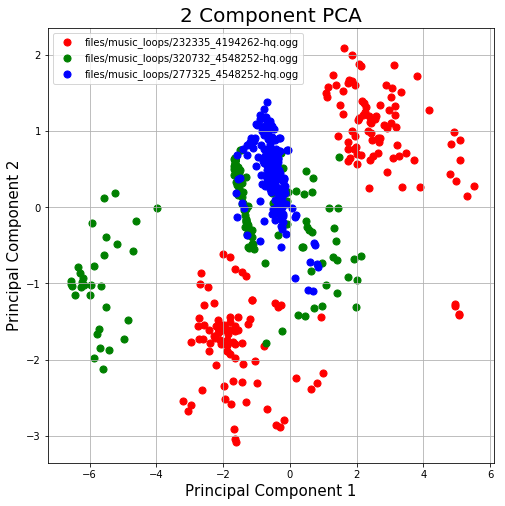

In [9]:


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

unique_paths = df['path'][:500].unique()[:3] #get 3 unique paths to plot
colors = ['r', 'g', 'b']
for target, color in zip(unique_paths,colors):
    indicesToKeep = finalDf['path'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(unique_paths)
ax.grid()

print("The explained variance tells us how much information (variance) can be attributed to each of the principal components: (it is recommended that components sum up at least to 0.95):\n")
print(pca.explained_variance_ratio_)



We can see below, that with MFCCs all the features are quite needed, as PCA to 95% needs 11 features. This would mean thta all features are important in explaining data variance (they are not correlated)

In [10]:
#as a curiosity, let's find out how many components needs the PCA algortihm to keep the 95 of the variance of the data.

#https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_to_Speed-up_Machine_Learning_Algorithms.ipynb

pca_95 = PCA(.95)

# Separating out the features
x_95 = df.loc[:, features].values
x_95 = StandardScaler().fit_transform(x_95) # Standardizing the features
pca_95.fit(x_95)

print("%s PCA components needed to contain 95percent variance, from the original %d features." % (pca_95.n_components_, x_95.shape[1]))


11 PCA components needed to contain 95percent variance, from the original 14 features.


## Plot audio and features

In [11]:
#utilities for pandas

#retrieve freesound_id for a given audio file path
def get_fs_id_from_path(df, sound_path):
    return df.loc[df['path'] == sound_path].iloc[0]['freesound_id']

def feature_values_by_path(df, sound_path, feature):
    return df.loc[df['path'] == sound_path][feature].values


#TODO do it with external library if possible?
def scale_list(mylist):
    '''normalize against the maximum'''
    maximum = max([abs(min(mylist)), abs(max(mylist))])
    return [float(i)/maximum for i in mylist]




# TODO: instead of scaling for the plot, maybe is it worth to sclae them after computing pca and leaving them sclaed all along?

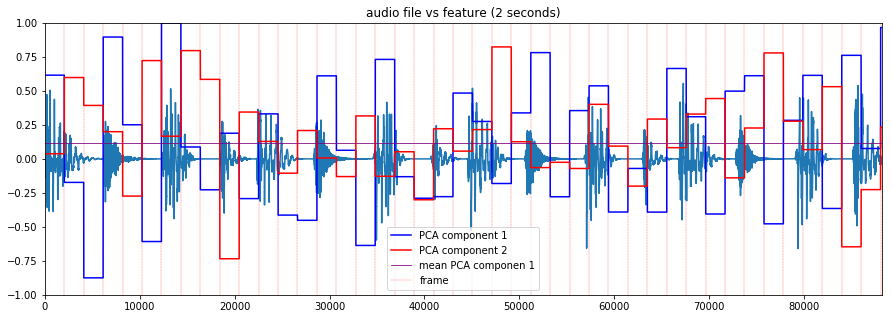

In [12]:
##PLOT Tests: at the moment only ine mfcc, we should perform PCA

# Plot first PCA component on top of audio sample

df = pd.read_csv(DATAFRAME_CSV_FILENAME_ANALYSIS_MUSIC_LOOPS)
sound_to_test_path = 'files/music_loops/102885_1676089-hq.ogg'

#at the moment only plot first component of PCA
scaler = MinMaxScaler(feature_range=(-1, 1))# will scale for plot
PCA_1 = feature_values_by_path(finalDf, sound_to_test_path, 'principal component 1')
normalized_PCA_1 = scaler.fit_transform(PCA_1.reshape(-1,1)) #normalize to fit into the plot

PCA_2 = feature_values_by_path(finalDf, sound_to_test_path, 'principal component 2')
normalized_PCA_2 = scaler.fit_transform(PCA_2.reshape(-1,1)) #normalize to fit into the plot


audio_df = df.loc[df['path'] == sound_to_test_path]

PCA_1_repeated = np.repeat(normalized_PCA_1, FRAME_SIZE_LOW_LEVEL) #repeat to fit into sample for plotting
PCA_1_mean = np.mean(PCA_1_repeated)
PCA_2_repeated = np.repeat(normalized_PCA_2, FRAME_SIZE_LOW_LEVEL) #repeat to fit into sample for plotting
PCA_2_mean = np.mean(PCA_2_repeated)



# Plot target audio file waveform and show ticks at the start samples of the chunks
seconds_to_plot = 2
plt.figure(figsize=(15,5))
audio = estd.EqloudLoader(filename=sound_to_test_path)()
plt.plot(audio)
plt.plot(PCA_1_repeated, 'blue', label="PCA component 1")
plt.plot(PCA_2_repeated, 'red', label="PCA component 2")
plt.plot(PCA_1_mean.repeat(44100 * seconds_to_plot), linewidth=0.8, color='purple', label="mean PCA componen 1")
plt.vlines(audio_df['start_sample'].values, -1, 1, color='red',  linestyle='dashed', linewidth=0.3, label="frame") # frame delimiters
plt.axis([0, min(len(audio), 44100 * seconds_to_plot ), -1, 1])
plt.title('audio file vs feature (%s seconds)' % seconds_to_plot)
plt.legend()
plt.show()

Audio(filename=sound_to_test_path)

#df.describe() # Show statistics of numerical fields in data frame, can be useful for a substet of a single track




## PLOT clusters and centroids with k-means
#### TODO Is is better to PCA after or before clustering?

(9613, 2)
[ 4  6 12 ...,  8  2  8]
[[ 1.28356913  0.51658819]
 [-1.8314295   0.53516541]
 [ 3.73688323 -2.13144668]
 [ 3.08324005  1.48969639]
 [ 1.06075256 -1.57995604]
 [-0.27735163  2.14131735]
 [-0.90653126 -0.77914407]
 [-3.44517887 -0.44013882]
 [ 2.30048908 -0.6710899 ]
 [ 0.46887599 -0.50888726]
 [-5.76535087 -0.54633732]
 [-2.19935045  3.5304814 ]
 [-2.24041396 -1.44006982]
 [ 1.4202222   4.50167913]
 [-0.44333645  0.47105304]
 [ 4.19068225  0.01789406]]


Text(0, 0.5, 'PCA2')

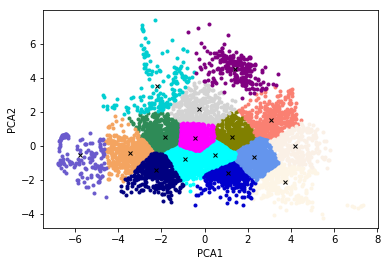

In [157]:
#https://musicinformationretrieval.com/kmeans.html
from sklearn.cluster import KMeans
from itertools import cycle
from matplotlib import colors


PCA_components = finalDf[['principal component 1', 'principal component 2']].values
print(PCA_components.shape)
features_2D = PCA_components # like this wecan change PCA for any other thing

#time to cluster! with k-means
k_means = KMeans(n_clusters=16)
k_means.fit_predict(PCA_components)
labels = k_means.labels_ 
centroids = k_means.cluster_centers_ #take the cluster center


print(labels)
print(centroids)


plt.close('all')
plt.figure(1)
plt.clf()

colors = list(colors.CSS4_COLORS.keys()) + list(colors.BASE_COLORS.keys()) #all available colors in python

for k, col in zip(range(len(centroids)), colors):
    class_members = labels == k
    cluster_center = centroids[k]
    plt.plot(features_2D[class_members, 0], features_2D[class_members, 1], '.', c=col) #paint all values of a cluster
    plt.plot(cluster_center[0], cluster_center[1],'x', markeredgecolor='k', markersize=4) #paint centroid

plt.xlabel('PCA1')
plt.ylabel('PCA2')


## Encode tracks with the obtained codebook, and compute histograms
Will create two dictionaries by_id, one with the encoded frames, and other with the histogram of this encode frames.
An histogram is a graphical representation of the value distribution.

##### The 1-nearest neighbor classifier : 
The most intuitive nearest neighbour type classifier is the one nearest neighbour classifier that assigns a point x to the class of its closest neighbour in the feature space.

In [282]:
from sklearn.neighbors import NearestNeighbors

features = ['principal component 1', 'principal component 2']    


def create_histograms(encoded_tracks_by_id, codebook):
    '''returns a dictionary with id and the corresponding histogram of encoded frames'''
    bins = create_bins_for_histogram(codebook)
    histograms_by_id = {} 
    for track_id in encoded_tracks_by_id.keys():
        histogram, _ = np.histogram(encoded_tracks_by_id[track_id], bins)
        histograms_by_id[track_id] = histogram
    return histograms_by_id


def create_bins_for_histogram(codebook):
    '''
    https://stackoverflow.com/questions/30112420/histogram-for-discrete-values-with-matplotlib
    the default bins will not be centered around the integer: 
    ... so the trick is to set up the bins centered on the integers, i.e.
    -0.5, 0.5, 1,5, 2.5, ... up to max(data) + 1.5. Then you substract -0.5 to eliminate the extra bin at the end.
    '''
    return np.arange(0, len(codebook) + 1.5) - 0.5


def encode_all_audios(codebook, dataframe, features):
    '''
    Codebook: array of n-dimensional points corresponding to codewords (cluster centroids)
       
    Will encode all audios, finding which is the nearest cluster centroid(code vector) for each frame.
    1-nearest-neighbour is used to get the closest centroid.
    Returns a dictionary by id and the corresponding array of encoded frames.
    '''
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(centroids) 
    unique_ids = dataframe['freesound_id'].unique() #get unique ids
    encoded_tracks_by_id = {}
    for track_id in unique_ids:
        encoded_track = encode_audio(track_id, dataframe, features)
        encoded_tracks_by_id[track_id] = encoded_track
    return encoded_tracks_by_id


def encode_audio(track_id, dataframe, features):
    file_frames = dataframe.loc[dataframe['freesound_id'] == track_id] # frames belonging the freesound_id
    frames_values = file_frames.loc[:, features].values 
    _, indices = nbrs.kneighbors(frames_values) #obtain the nearest centroid for each frame on the input
    return indices.squeeze() # squeeze will get rid of unnecesary dimesions



#encode all tracks:
encoded_tracks_by_id = encode_all_audios(centroids, finalDf, features)    
print('encoded_tracks_by_id was computed')

#create histograms:
histograms_by_id = create_histograms(encoded_tracks_by_id, centroids)
print('histograms_by_id was computed')

    

encoded_tracks_by_id was computed
histograms_by_id was computed


### Plot some histograms:
https://matplotlib.org/gallery/subplots_axes_and_figures/subplots_demo.html


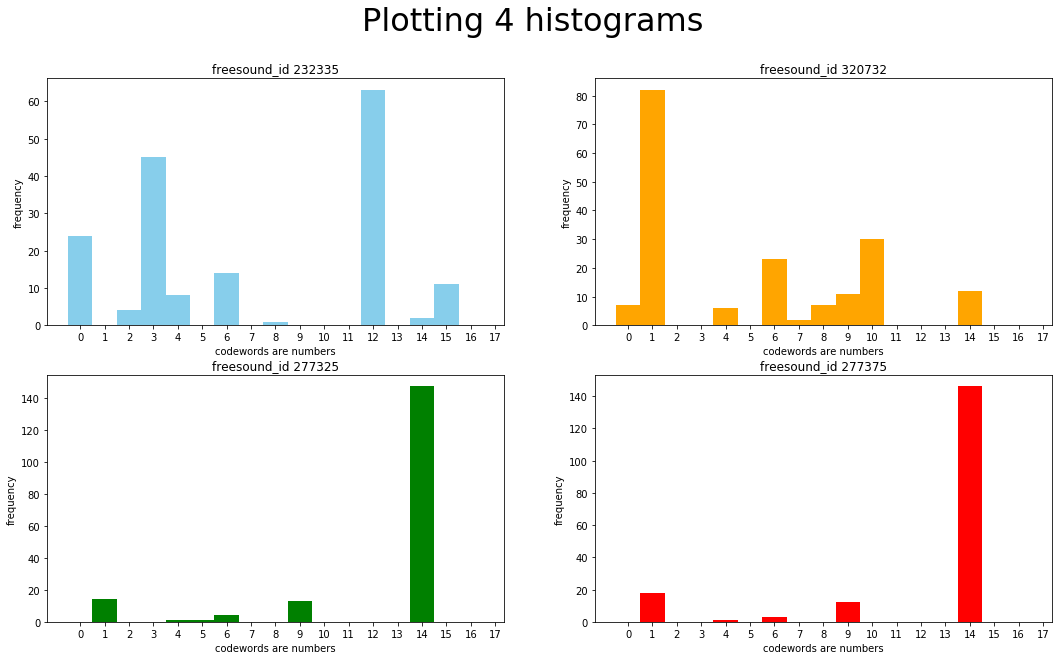

In [283]:
#test_id = 232335

plot_ids = finalDf['freesound_id'].unique()[:4] #get 4 unique ids to plot

#for plotting, we use matplotlib instead on numpy.histogram:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Plotting 4 histograms', fontsize=32)

axs[0, 0].hist(encoded_tracks_by_id[plot_ids[0]], bins, color = "skyblue")  
axs[0, 0].set_title('freesound_id {}'.format(plot_ids[0]))
axs[0, 0].set_xticks(bins + 0.5)
axs[0, 1].hist(encoded_tracks_by_id[plot_ids[1]], bins, color = "orange")  
axs[0, 1].set_title('freesound_id {}'.format(plot_ids[1]))
axs[0, 1].set_xticks(bins + 0.5)
axs[1, 0].hist(encoded_tracks_by_id[plot_ids[2]], bins, color = "green")  
axs[1, 0].set_title('freesound_id {}'.format(plot_ids[2]))
axs[1, 0].set_xticks(bins + 0.5)
axs[1, 1].hist(encoded_tracks_by_id[plot_ids[3]], bins, color = "red")
axs[1, 1].set_title('freesound_id {}'.format(plot_ids[3]))
axs[1, 1].set_xticks(bins + 0.5)

for ax in axs.flat:
    ax.set(xlabel='codewords are numbers', ylabel='frequency')


# Compare histograms

https://stats.stackexchange.com/questions/7400/how-to-assess-the-similarity-of-two-histograms

### Approach 1: intersection 
simple!


In [286]:
#https://mpatacchiola.github.io/blog/2016/11/12/the-simplest-classifier-histogram-intersection.html

def return_intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection

test_ids = finalDf['freesound_id'].unique()[:4] #get 4 unique ids to test

print (return_intersection(histograms_by_id[test_ids[0]], histograms_by_id[test_ids[0]]))
print (return_intersection(histograms_by_id[test_ids[0]], histograms_by_id[test_ids[1]]))
print (return_intersection(histograms_by_id[test_ids[2]], histograms_by_id[test_ids[3]])) 


1.0
0.166666666667
0.977777777778


### Approach 2: Cosine similarity
Cosine similarity is a metric used to measure how similar the documents are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space.

https://www.machinelearningplus.com/nlp/cosine-similarity/

## TODO: Soft Cosine Similarity?
If you want a similarity metric that gives higher scores for documents belonging to the same topic and lower scores when comparing docs from different topics.

In [340]:
# Define the documents
doc_trump = "Mr. Trump became president after winning the political election. Though he lost the support of some republican friends, Trump is friends with President Putin"

doc_election = "President Trump says Putin had no political interference is the election outcome. He says it was a witchhunt by political parties. He claimed President Putin is a friend who had nothing to do with the election"

doc_putin = "Post elections, Vladimir Putin became President of Russia. President Putin had served as the Prime Minister earlier in his political career"

documents = [doc_trump, doc_election, doc_putin]


#test: treat encoded vectors as text documents!



# Scikit Learn
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

'''
NOTE:
Even better, I could have used the TfidfVectorizer() instead of CountVectorizer(), 
because it would have downweighted words that occur frequently across docuemnts.'''


## What I could do, is to provd 

# Create the Document Term Matrix
#count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(documents)

# OPTIONAL: Convert Sparse Matrix to Pandas Dataframe if you want to see the word frequencies.
doc_term_matrix = sparse_matrix.todense()
df = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=['doc_trump', 'doc_election', 'doc_putin'])
df

# Compute Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(df, df))
#> [[ 1.          0.48927489  0.37139068]
#>  [ 0.48927489  1.          0.38829014]
#>  [ 0.37139068  0.38829014  1.        ]]

#print(sparse_matrix)
df.shape

[[ 1.          0.51480485  0.38890873]
 [ 0.51480485  1.          0.38829014]
 [ 0.38890873  0.38829014  1.        ]]


(3, 48)

### TD IDF: obtain similarity matrix
## TODO:  I could have used the TfidfVectorizer() instead of CountVectorizer()

https://www.machinelearningplus.com/nlp/cosine-similarity/

Also more info in: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

In [369]:
#https://www.machinelearningplus.com/nlp/cosine-similarity/
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

'''
TODO:
Even better, I could have used the TfidfVectorizer() instead of CountVectorizer(), 
because it would have downweighted words that occur frequently across docuemnts.
'''


def convert_encoded_tracks_as_text(encoded_tracks_by_id):
    encoded_tracks_as_text_by_id = {}
    for track_id in encoded_tracks_by_id.keys():
        encoded_track_as_text = ' '.join('c' + str(e) for e in encoded_tracks_by_id[track_id])
        encoded_tracks_as_text_by_id[track_id] = encoded_track_as_text
    return encoded_tracks_as_text_by_id
    
encoded_tracks_as_text_by_id = convert_encoded_tracks_as_text(encoded_tracks_by_id)

#tf-idf algorithm requires to provide an array for texts:
track_ids = np.array([])
tracks_as_text = np.array([])
for track_id in encoded_tracks_as_text_by_id.keys():
    track_ids = np.append(track_ids, track_id)
    tracks_as_text = np.append(tracks_as_text, encoded_tracks_as_text_by_id[track_id])  

documents = tracks_as_text # this is our text corpus


# Create the Document Term Matrix
#count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(documents)

# OPTIONAL: Convert Sparse Matrix to Pandas Dataframe if you want to see the word frequencies.
doc_term_matrix = sparse_matrix.todense()
df = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=track_ids)

#print(sparse_matrix)

similarity_matrix = cosine_similarity(df) # Compute Cosine Similarity between rows
print(similarity_matrix.shape)
print(similarity_matrix)
df.head(10)


(60, 60)
[[ 1.          0.57805505  0.60665155 ...,  0.26942671  0.27669124
   0.40262725]
 [ 0.57805505  1.          0.75728998 ...,  0.53507528  0.34068135
   0.37570232]
 [ 0.60665155  0.75728998  1.         ...,  0.66325996  0.61470802
   0.37582434]
 ..., 
 [ 0.26942671  0.53507528  0.66325996 ...,  1.          0.26090006
   0.08988621]
 [ 0.27669124  0.34068135  0.61470802 ...,  0.26090006  1.          0.36499605]
 [ 0.40262725  0.37570232  0.37582434 ...,  0.08988621  0.36499605  1.        ]]


,c0,c1,c10,c11,c12,c13,c14,c15,c2,c3,c4,c5,c6,c7,c8,c9
256257.0,31,16,8,2,3,0,21,0,2,0,5,19,6,9,33,6
340483.0,3,24,0,11,0,0,12,2,8,3,13,20,13,0,2,3
259717.0,6,21,9,3,10,0,14,0,0,2,7,16,24,19,1,15
431873.0,20,23,0,0,9,0,25,4,8,0,3,3,69,0,26,5
188552.0,6,27,0,0,13,0,4,0,12,0,9,0,12,32,47,10
428681.0,28,0,0,0,0,0,9,1,1,2,32,0,16,0,34,85
232335.0,24,0,0,0,63,0,2,11,4,45,8,0,14,0,1,0
30225.0,2,24,2,48,1,0,12,0,0,0,0,41,6,20,0,0
213523.0,16,4,0,0,0,0,22,0,0,4,16,6,35,1,4,64
190612.0,9,0,0,0,0,0,0,0,5,0,71,0,6,0,21,49


In [ ]:
'''
TODO
# https://pythonprogramminglanguage.com/kmeans-text-clustering/
# simple example for clustering right after tf-idf (without posterior cosine similarity matrix)

#we can even predict something next, see last lines in: 
https://github.com/MihailSalnikov/tf-idf_and_k-means/blob/master/main.ipynb

'''


## TF-IDF alternatives for text clustering?
https://datascience.stackexchange.com/questions/33227/what-approach-other-than-tf-idf-could-i-use-for-text-clustering-using-k-means
 In this response:
 - Like Tf-Idf, GloVe represents a group of words as a vector. Unlike Tf-Idf, which is a Bag-of-Words approach, GloVe and similar techniques preserve the order of words in a tweet. Knowing what word comes before or after a word of interest is valuable information for assigning meaning
 - For your clustering, I recommend checking out Density-Based clustering. K-means is a decent all-purpose algorithm, but it's a partitional method and depends on assumptions that might not be true, such as clusters being roughly equal in size.

Further links:


### word2vec:
In data clustering algorithms instead of bag of words (BOW) model we can use Word2Vec. The advantage of using Word2Vec is that it can capture the distance between individual words.

Each word will be converted in a vector of the specified bit length.
==> very easy to cluster "similar" words

seems easy to do as well: https://www.youtube.com/watch?v=thLzt3D-A10
 Gensim Python library
obviously, for our poutpose we need to train the model ourself, 
https://github.com/shreyans29/thesemicolon/blob/master/word2vec.py

can also get `mostsimilar`

### doubt: but then, can I cluster the documents? how?





----
Maybe this is also interesting!!!

(both clusterings are with k-means)

(document level) --> Text Clustering with doc2vec :
http://ai.intelligentonlinetools.com/ml/text-clustering-doc2vec-word-embedding-machine-learning/

(sentence level) --> Text Clustering with Word Embedding word2vec
http://ai.intelligentonlinetools.com/ml/text-clustering-word-embedding-machine-learning/

(otherwise, we would only be able to cluster at a word level, since words are n-dimesional vectors)

`Doc2Vec` (also called Paragraph Vectors) is an extension of Word2Vec, which learns the meaning of documents instead of words.
paper --> https://arxiv.org/pdf/1607.05368.pdf
interesting idea after clustering --> we counted the number of occurrences of each word. We then selected the 5 most occurring words per cluster as keywords for that cluster. This approach worked surprisingly well. 

---



check also
### 2.1.3 Co-Occurrence Matrix with a fixed context window 
https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/


In [419]:
def sim_to_dist(m):
    '''
    converts similarity to distance matrix
    uses vectorized ufunc for better performance: 
    https://stackoverflow.com/questions/42594695/how-to-apply-a-function-map-values-of-each-element-in-a-2d-numpy-array-matrix?rq=1
    
    possible performance improvement here (we only need to compute the upper half on the diagonal):
    https://stackoverflow.com/questions/25650100/use
    º-a-similarity-function-for-clustering-scikit-learn 
    At the moment it is fast, so I didn't do it so far.
    '''
    return np.round((1 - m), 6)

distance_matrix = sim_to_dist(similarity_matrix) # faster using numpy built-in ufuncs
distance_matrix


array([[ 0.      ,  0.421945,  0.393348, ...,  0.730573,  0.723309,
         0.597373],
       [ 0.421945,  0.      ,  0.24271 , ...,  0.464925,  0.659319,
         0.624298],
       [ 0.393348,  0.24271 ,  0.      , ...,  0.33674 ,  0.385292,
         0.624176],
       ..., 
       [ 0.730573,  0.464925,  0.33674 , ...,  0.      ,  0.7391  ,
         0.910114],
       [ 0.723309,  0.659319,  0.385292, ...,  0.7391  ,  0.      ,
         0.635004],
       [ 0.597373,  0.624298,  0.624176, ...,  0.910114,  0.635004,  0.      ]])

## Hierarchical clustering and dendogram:
not sure if needed, but I leave the idea here just in case.

In [380]:
# 6- Use a hierarchical clustering algorithm to cluster subgenres. 
#Visualize dendrograms (generate a huge high-resolution dendrogram image listing all analyzed subgenres). 
#This will be a very huge image to fit in the report, so it may be better to arrange it in a way that the subgenres are stacked vertically (or include it as an attachment pdf/png). 
#Consider showing just a few zoomed-in images of interesting genres.

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html

%matplotlib inline
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib 


dist = similarity_matrix 

#Perform hierarchical/agglomerative clustering.
Z = linkage(dist, optimal_ordering=True)

plt.figure(figsize=(300, 100))

min_threshold = 200
plt.title('Hierarchical clustering dendrogram of sub-genres on 4 different sources dataset using a threshold of minimum '
          +str(min_threshold), fontsize = 20)
plt.xlabel('sample index')
plt.ylabel('subgenre label')

#dendrogram(Z, labels=subgenres_to_keep)
dendrogram(
    Z,
#    labels=subgenres_to_keep,
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)



#plt.savefig("dendogram.png", facecolor=('white'), edgecolor='none')
plt.show()

## A different aproach on hierarchical clustering and dendogram.
# TODO: correct labels on dendogram: 
in stack overflow the first option is provided but I don't understand why we do this : linkage = hcluster.linkage(1 - distVec)

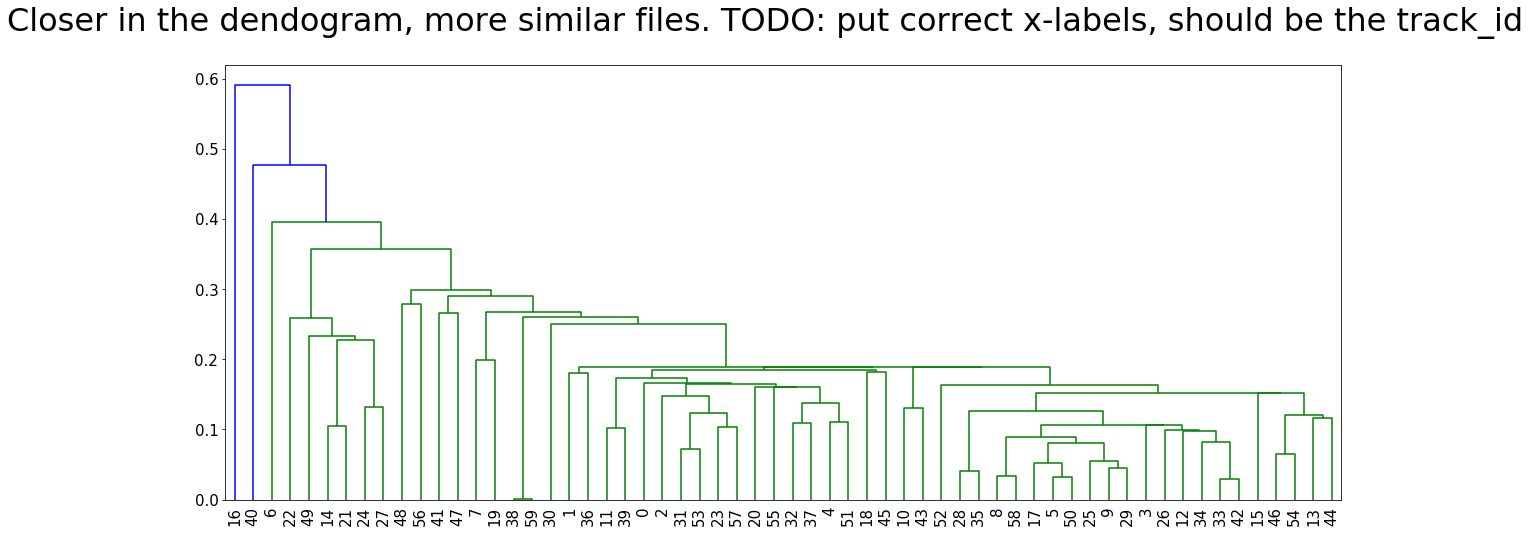

very far away:
0.0
0.0
0.521953426364
not so similars:
0.36472831458
0.241621033001
0.599384236911
0.475091826342
0.0379574356348
0.0379574356348
0.570151002885
similars
0.9663538538
0.890525009055
0.967774789536
0.955215609802
0.928176719031
0.999553452695


In [462]:
'''
A way to pass this similarity matrix through to the dendrogram so it plots correctly:
Turns out the SimMatrix needs to be first converted into a condensed matrix 
(the diagonal, upper right or bottom left, of this matrix):

https://stackoverflow.com/questions/29022451/dendrogram-through-scipy-given-a-similarity-matrix?rq=1
'''
import scipy.cluster.hierarchy as hcluster
import scipy.spatial.distance as ssd


fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(1, 1, 1)

distVec = ssd.squareform(distance_matrix)
linkage = hcluster.linkage(distVec)
dendro  = hcluster.dendrogram(linkage)

fig.suptitle('Closer in the dendogram, more similar files. TODO: put correct x-labels, should be the track_id', fontsize=32)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.tick_params(axis='x', which='major', labelsize=15)
plt.show()


#fig.savefig('t.png')


print('very far away:')
print(similarity_matrix[16, 40])
print(similarity_matrix[16, 44])
print(similarity_matrix[44, 40])


print('not so similars:')
print(similarity_matrix[22, 49])
print(similarity_matrix[20, 1])
print(similarity_matrix[20, 55])
print(similarity_matrix[8, 37])
print(similarity_matrix[6, 40])
print(similarity_matrix[40, 6])
print(similarity_matrix[22, 25])

print('similars')
print(similarity_matrix[8, 58])
print(similarity_matrix[32, 37])
print(similarity_matrix[5, 50])
print(similarity_matrix[9, 29])
print(similarity_matrix[31, 53])
print(similarity_matrix[38, 59])




### heatmap with dendogram

https://python-graph-gallery.com/404-dendrogram-with-heat-map/

When you use a dendrogram to display the result of a cluster analysis, it is a good practice to add the corresponding heatmap. It allows you to visualise the structure of your entities (dendrogram), and to understand if this structure is logical (heatmap).  This is easy work thanks to the seaborn library that provides an awesome ‘cluster map’ function. This page aims to describe how it works, and note that once more the seaborn documentation is awesome.

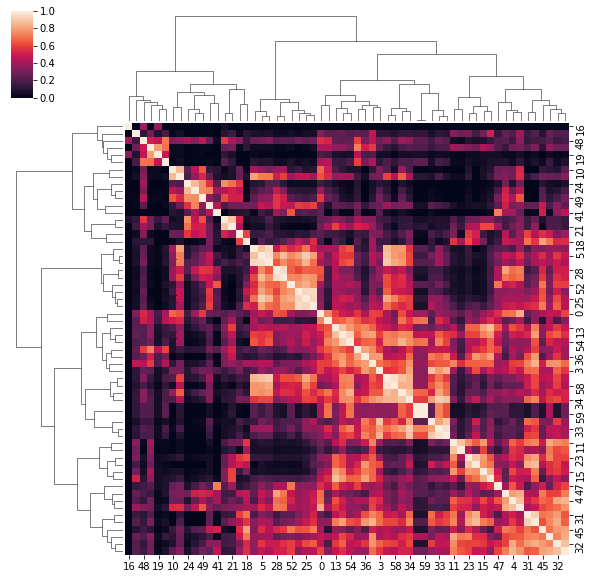

In [464]:
sns.clustermap(similarity_matrix, metric="euclidean", standard_scale=1, method="ward")

# Clustering tracks from the cosine distance similarity matrix:
https://stackoverflow.com/questions/30089675/clustering-cosine-similarity-matrix
https://towardsdatascience.com/spectral-clustering-for-beginners-d08b7d25b4d8

## TODO: Take a better look if I am doing this properly (providing correct matrix and hyperparameters)

## TODO: Can also use hierarchical clustering if the dataset is not too big (it is expensive)

`SpectralClustering`: using `precomputed`, a user-provided affinity matrix (similarity matrix) can be used.

For the cases you want the algorithm to figure out the number of clusters by itself, you can use Density Based Clustering Algorithms like DBSCAN:
 

In [478]:
import numpy as np
from sklearn.cluster import SpectralClustering
#mat = np.matrix([[1.,.1,.6,.4],[.1,1.,.1,.2],[.6,.1,1.,.7],[.4,.2,.7,1.]])


clusters = SpectralClustering(20, affinity="precomputed").fit_predict(similarity_matrix) # we provide our precomputed affinity(similarity) matrix
print(len(clusters))
clusters


60


array([10, 12, 15,  3, 19,  5,  4, 12,  5, 11, 10,  6, 13, 18,  1,  6,  2,
        5,  4,  2, 19,  1, 16,  4,  1, 11,  3, 16, 19, 11, 10,  4,  9,  3,
       14, 19,  3,  6, 18,  6, 17,  0,  3,  5, 17,  4,  7,  0,  2,  1,  5,
       19,  0,  8, 18,  6,  2,  4,  5, 18], dtype=int32)

#### For the cases you want the algorithm to figure out the number of clusters by itself, you can use Density Based Clustering Algorithms like DBSCAN:

In [477]:
'''
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
 NOTE/TODO: (...)One way to avoid the query complexity is to pre-compute sparse neighborhoods in chunks using NearestNeighbors.radius_neighbors_graph with mode='distance', then using metric='precomputed' here.
'''
# Perform DBSCAN clustering from vector array or distance matrix
'''
TODO: check this as well: 
https://stackoverflow.com/questions/53194672/sklearn-dbscan-cosine-vs-precomputed
 Am I dealing with cosine distance correctly? In here says:

(...)The linear kernel and cosine distance are close mathematically 
but the linear kernel will give 1 for full similarity, whereas a cosine distance for full similarity is 0, so (...)
'''

#works with DISTANCE matrix (from documentation)
from sklearn.cluster import DBSCAN
DBSCAN(min_samples=1).fit_predict(distance_matrix)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5,
       50, 51, 52, 53, 54, 55, 56, 57, 38])

# Affinity propagation:
# TODO: I think is not needed anymore
In scikit-learn, other clustering algorithms such as affinity propagation can cluster without defining the number of clusters beforehand.

TODO: All we need to do is swap out KMeans for AffinityPropagation:

### But crashes because to many PCA_components (until 3000 it "resists")

https://musicinformationretrieval.com/kmeans.html

[39  1  1  4  1  1  4  4  4  6 42  4  6  4  4  4  4 42  6 46  2  8  5  0  0
  8  8  3  8  8  8  8  3  9  9  9  9  9  3  9  3  9  3 36  1  1  4  1  1  4
  4  4  6 42  4  6  4  4  4  4  6  6 46  2 18  5  0  0  8  8  3  8  8  8  8
  3  8  9  9  9  9  3  9  3  3  3 36  1  1  4  1  1  4  4  4  6 42  4  4  4
 46  4  4  6  6 46  2  2  5  0  0  8  8  3  8  8  8  8  3  8  9  9  9  9  9
  9  9  9  3 36  1  1  4  1  1 42  4  4  6 42  4  4  4 46 46  4  4  6 36  2
  7  5  0  0  8  8  3  8  9  8  8  8  8  9  9  9  8  9  9  9  9  3 37 14 13
 13 13 15 12 15 15 12 15 11 37 32 15 15 15 11 14 13 13 13 15 15 15 10 15 15
 43 12 15 11 12 43 37 37 15 15 15 12 12 15 15 12 15 37 14 13 13 13 15 12 15
 15 12 15  9 43 15 15 15 15 39 14 13 13 48 15 15 46 38 12 15 43 12 15 43 18
 26 37 11 15 15 15 12 12 15 15 12 15 36 14 13 13 13 15 12 15 15 12 15 37 37
 15 15 15 15 39 14 13 13 48 15 15 26 25 15 15 23 12 15 25 23 26 37 43 15 15
 15 12 12 15 15 12 15 39 14 14 13 47 15 12 15 15 12 15 37 43 15 15 15 15 46
 14 13 13 48

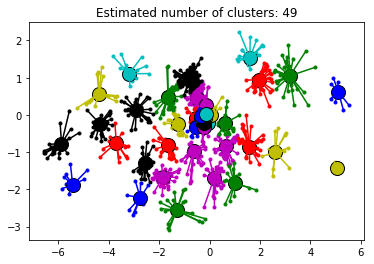

In [422]:
# AffinityPropagation and Plot result (https://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html)
from sklearn.cluster import AffinityPropagation
from itertools import cycle


af = AffinityPropagation()
X = PCA_components[:1000] #CRASHES if we use all
labels = af.fit_predict(X) 
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

#print(labels)
print('Estimated number of clusters: %d' % n_clusters_)

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]: # this part is computationally Very expensive, can kill kernel and is not really needed
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col) #draw lines to centroid

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## TODO (from Xavier):
 * codebook encoding
 * histogram ()
 * similarity function/matrix over the "codebook features" (varias opciones seguramente)
 * plot: plot features and their mean to show how different they are

next week with xavier:
 * degree clustering xavier technique

## SOTA:
 * Codebook:

https://www.sciencedirect.com/topics/engineering/vector-quantization 
Each input vector can be viewed as a point in an n-dimensional space. The vector quantizer is defined by a partition of this space into a set of nonoverlapping n-dimensional regions. The vector is encoded by comparing it with a codebook consisting of a set of stored reference vectors known as codevectors. 
 The optimality criterion is that a quantization region should consist of all vectors that are closer to its codevector than any of the other codevectors, and the codevector should be the average of all vectors that are in the quantization region.
 //Ali Grami, in Introduction to Digital Communications, 2016, chapter 5.2.3 Vector Quantization


Vector quantization (VQ) provides an efficient technique for data compression. Compression is achieved by transmitting the index of the codeword instead of the vector itself.
 VQ can be defined as a mapping that assigns each vector x=(x0,x1,…,xn-1)T in the n-dimensional space Rn to a codeword from a finite subset of Rn. The subset Y={yi:i=1,2,…,M} representing the set of possible reconstruction vectors is called a codebook of size M. Its members are called the codewords. In the encoding process, a distance measure is evaluated to locate the closest codeword for each input vector x. Then, the address corresponding to the codeword is assigned to x and transmitted. 
 A vector quantizer achieving a minimum encoding error is referred to as a Voronoi quantizer. Figure 7.9 shows an input data space partitioned into four different regions, called Voronoi cells, and the corresponding Voronoi vectors. These regions describe the collection of only those input vectors that are very close to the respective Voronoi vector.
 //Anke Meyer-Baese, Volker Schmid, in Pattern Recognition and Signal Analysis in Medical Imaging (Second Edition), 2014
 
 
  Thus the entire space Sb is divided into a finite number of cells and a code point is associated with each one. The code point is used to represent all of the points in that cell during the clustering process. The point with the smallest function value of a cell is the most suitable code point. Further, code points need not be sample points; they can be generated independently. They may also be centroids of the cells. Identification of a cluster is done using vector quantization of the reduced sample points. 
  // Jasbir Singh Arora, in Introduction to Optimum Design (Fourth Edition), 2017
 
 
 
 
 ----
 More on this but different:
 * Learnig Vector Quantisation: 
 Recent developments in neural network architectures have led to a new VQ concept, the so-called learning vector quantization (LVQ). It represents an unsupervised learning algorithm associated with a competitive neural network consisting of one input and one output layer. The algorithm permits only the update of the winning prototype, that is, the closest prototype (Voronoi vector) of the LVQ network.
  LVQ procedures are intuitively clear and easy to implement. The classification of data is based on a comparison with a number of so-called prototype vectors.
The relative simplicity of the LVQ and its ability to work in unsupervised mode have made it a useful tool for image segmentation problems [190]
 
 
 
 //k-means for example can be used for vector quantization, taking the centroid of each cluster as the codebook.
In computer vision, the bag-of-words model (BoW model) can be applied to image classification, by treating image features as words. In document classification, a bag of words is a sparse vector of occurrence counts of words; that is, a sparse histogram over the vocabulary. In computer vision, a bag of visual words is a vector of occurrence counts of a vocabulary of local image features.
https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision#cite_note-feifeicvpr2005-1
 
 
------- 
------- 
( 
https://machinelearningmastery.com/implement-learning-vector-quantization-scratch-python/
LVQ is a supervised version of vector quantization that can be used when we have labelled input data.
A limitation of k-Nearest Neighbors is that you must keep a large database of training examples in order to make predictions.

The Learning Vector Quantization algorithm addresses this by learning a much smaller subset of patterns that best represent the training data.
Predictions are made by finding the best match among a library of patterns. The difference is that the library of patterns is learned from training data, rather than using the training patterns themselves

(In LVQ) The library of patterns are called codebook vectors and each pattern is called a codebook. The codebook vectors are initialized to randomly selected values from the training dataset. Then, over a number of epochs, they are adapted to best summarize the training data using a learning algorithm.
 )



---
(Importance of Vector Quantization in Audio Signals Processing)
https://www.dsprelated.com/thread/3543/importance-of-vector-quantization-in-audio-signals-processing
The mathematical construction of GMMs allows people to apply fancy training criterion, especially those that make statistical sense, e.g. max likelihood or max a posteriori or minimum phoneme error rate. That also brings in a lot of computational complexity though. On the contrary, plain VQ requires just a discrete HMM, trainable with the textbook version of EM algorithm, an order of magnitude faster than HMM-GMM.

By 2000s computers are fast enough that none of those presents a problem unless you're doing the so called deep learning stuffs.

## DUDAS PARA XAVIER:
* Fuzzy clustering para codebook: En vez de fuzzy clustering, podriamos hacer el codebook con "hard" clustering (eg k-means) y hacer k-nn <1? (entonces quiza no sabríamos el porcentaje?)